In [47]:
!pip3 install sqlalchemy

Python(99018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 846.8 kB/s eta 0:00:00:0100:01


In [10]:
from openai import OpenAI
import datetime
import json

client = OpenAI(api_key='sk-proj-ZoaaVV0YvbIKJXwteiNDT3BlbkFJ04nNFE005MpoksRMN7TS')

# OPENAI_API_KEY = 'sk-proj-ZoaaVV0YvbIKJXwteiNDT3BlbkFJ04nNFE005MpoksRMN7TS'

# List of profiles to analyze
profiles = [
    "Anas Sarwar", "Vaughan Gething", "Richard Tice"
]

# Define the start date for tweet analysis
start_date = datetime.datetime(2024, 5, 22, 13, 0)

# Function to fetch tweets for a given profile since a specific date
def fetch_tweets(profile_name, start_date):
    with open('tweets2.json', 'r') as file:
        data = json.load(file)
    
    # Filter tweets for the profile and after the start date
    profile_tweets = [
        tweet for tweet in data
        if 'user' in tweet and 'name' in tweet['user'] and tweet['user']['name'] == profile_name and
           'created_at' in tweet and datetime.datetime.strptime(tweet['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ') >= start_date
    ]
    return profile_tweets

# Function to analyze tweets using OpenAI
def analyze_tweets(profile_name, tweets):
    tweets_text = "\n".join(tweet['full_text'] for tweet in tweets)
    
    prompt = f"""
    Use the provided data to produce a concise analysis of the tweets and their sentiment towards the election. Note key factors such as common topics, implications for local elections, and overall sentiment.
    
    ###Profile###
    Profile: {profile_name}

    Tweets: {tweets_text}
    
    ###
    """
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

# Main execution loop
analysis_results = {}

for profile in profiles:
    tweets = fetch_tweets(profile, start_date)
    if tweets:
        analysis = analyze_tweets(profile, tweets)
        analysis_results[profile] = analysis
        print(f"Analysis for {profile}:\n{analysis}\n")
    else:
        analysis_results[profile] = "No new tweets found since {}".format(start_date)
        print(f"No new tweets found for {profile} since {start_date}\n")

# Write the analysis results to a JSON file
with open('analysis_results.json', 'w') as file:
    json.dump(analysis_results, file, indent=4)

Analysis for Anas Sarwar:
### Analysis of Anas Sarwar's Tweets and Their Sentiment Towards the Election

**Summary:**
The analysis presents a cohesive sentiment and focus across Anas Sarwar's tweets regarding the upcoming election. The dominant theme is a call for change and the premise that Labour is equipped to facilitate this transformation. 

**Common Topics:**
1. **Call for Change:** The recurrent theme throughout the tweets is a strong emphasis on the need for change. The phrase “It’s time for change” is repeatedly used, indicating a central campaign message.
2. **Criticism of Tory Leadership:** Specific mention is made of “14 years of Tory chaos,” suggesting a critical stance towards the Conservative party's track record.
3. **Promotion of Labour:** The tweets consistently promote Scottish Labour as the vehicle for this proposed change, emphasizing readiness and capability to deliver.

**Implications for Local Elections:**
- **Aligning with National Narrative:** The tweets align

In [49]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Define the POSTGRES_URI
POSTGRES_URI = "postgresql://udvgghkgvhno05:pdb4ac0e3d9341327385cc1514256906b3ea3cee34a8bfca9f9878e3ecb829408@c6i386kdr73gcp.cluster-czz5s0kz4scl.eu-west-1.rds.amazonaws.com:5432/d3p1stj7ab710b"

# Create a connection to the database
engine = create_engine(POSTGRES_URI)

# Define the SQL query
query = """
SELECT 
    "census2021-ts001-oa"."Residence_type_Total;_measures_Value" AS population,
    "census2021-ts001-oa"."geography",
    "census2021-ts001-oa"."geography_code",
    "census2021-ts006-oa"."Population_Density_Persons_per_square_kilometre;_measures_Value" AS population_density,
    "census2021-ts021-oa"."geography" AS ethnicity_geography,
    "census2021-ts021-oa"."geography_code" AS ethnicity_geography_code
FROM 
    "census2021-ts001-oa"
JOIN 
    "census2021-ts006-oa" ON "census2021-ts001-oa"."geography_code" = "census2021-ts006-oa"."geography_code"
WHERE 
    "census2021-ts001-oa"."geography" IS NOT NULL
    AND "census2021-ts006-oa"."geography" IS NOT NULL;
"""

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, engine)

# Save the DataFrame to a CSV file
df.to_csv('census_data.csv', index=False)

print("Data has been successfully downloaded and saved to census_data.csv")

Data has been successfully downloaded and saved to census_data.csv


In [50]:
from bs4 import BeautifulSoup
import csv

# Load the HTML content
with open('bad_table.html', 'r') as file:
    html_content = file.read()

# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table
table = soup.find('tbody')

# Open a CSV file to write to
with open('poll_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Iterate over each row in the table
    for row in table.find_all('tr'):
        csv_row = []
        # For each cell in the row, get the text and append to the csv_row list
        for cell in row.find_all(['th', 'td']):
            csv_row.append(cell.get_text())
        # Write the csv_row to the CSV file
        writer.writerow(csv_row)

In [75]:
import pandas as pd
import random

# Load the population data from the CSV file
demographics_df = pd.read_csv('demographic_data.csv')

# Load electorate turnout data
turnout_df = pd.read_csv('electorate-turnout.csv')

# Load constituency to geography mapping
constituency_lookup_df = pd.read_csv('lad_constituency_lookup.csv')

# Vote intention weightings based on the YouGov article
party_weights = {
    "CON%": 20,
    "LAB%": 47,
    "LIB%": 8,
    "Reform%": 9,
    "Green%": 11,
}

# Normalize weights to create a probability distribution
total = sum(party_weights.values())
for party in party_weights:
    party_weights[party] /= total

# Age group turnout from the notebook
age_group_turnout = {
    'age 20 24': 54.5,
    'age 25 29': 54.4, 'age 30 34': 60.9, 'age 35 39': 60.9, 'age 40 44': 71.0,
    'age 45 49': 71.0, 'age 50 54': 72.8, 'age 55 59': 72.8, 'age 60 64': 78.5,
    'age 65 69': 78.5, 'age 70 74': 78.5, 'age 75 79': 78.5, 'age 80 84': 78.5,
    'age 85 and over': 78.5
}

# Function to choose a party based on weights
def choose_party(weights):
    parties, probs = zip(*weights.items())
    return random.choices(parties, weights=probs, k=1)[0]

# Function to randomly select an age group based on population distribution
def choose_age_group(row):
    excluded_groups = ['age 0 4', 'age 5 9', 'age 10 14', 'age 15 19']
    age_groups = [col for col in row.index if 'age' in col and col not in excluded_groups and pd.notna(row[col]) and row[col] > 0]
    populations = [row[age] for age in age_groups]
    total_population = sum(populations)
    if total_population == 0:
        return None  # Handle cases where no population data is available
    probabilities = [p / total_population for p in populations]
    return random.choices(age_groups, weights=probabilities, k=1)[0]

# Generate fake polling data
data = []
for index, row in demographics_df.iterrows():
    geography = row['geography']
    population = int(row['population'])
    num_rows = population // 100  # Generate one row per 100 people

    # Get electorate turnout for the geography's (LAD) constituency by matching LAD22NM in constituency_lookups_df with PCON22NM. 
    constituency_matches = constituency_lookup_df[constituency_lookup_df['LAD22NM'] == geography]
    if not constituency_matches.empty:
        constituency_name = constituency_matches['PCON22NM'].iloc[0]
        electorate_info = turnout_df[turnout_df['Constituency name'] == constituency_name]
        if not electorate_info.empty:
            total_votes = electorate_info['Valid votes'].iloc[0]
            total_electorate = electorate_info['Electorate'].iloc[0]
            overall_turnout = (total_votes / total_electorate) * 100

            # Get possible geographies for the constituency
            geographies = constituency_lookup_df[constituency_lookup_df['PCON22NM'] == constituency_name]['LAD22NM'].tolist()

            for _ in range(num_rows):
                if not geographies:
                    continue  # Skip if no geographies are found for the constituency
                location = random.choice(geographies)  # Randomly select a geography
                age_group = choose_age_group(row)
                if age_group is None:
                    continue  # Skip if no valid age group is found
                age_turnout = age_group_turnout.get(age_group, 0)
                vote_likelihood = (age_turnout / 100) * (overall_turnout / 100)
                vote_intention = 'y' if random.random() < vote_likelihood else 'n'
            party = choose_party(party_weights) if vote_intention == 'y' else None
            data.append([constituency_name, location, vote_intention, party, age_group])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Constituency', 'LTLA', 'Vote Intention', 'Party', 'Age Group'])

# Save to CSV
df.to_csv('fake_polling_data.csv', index=False)

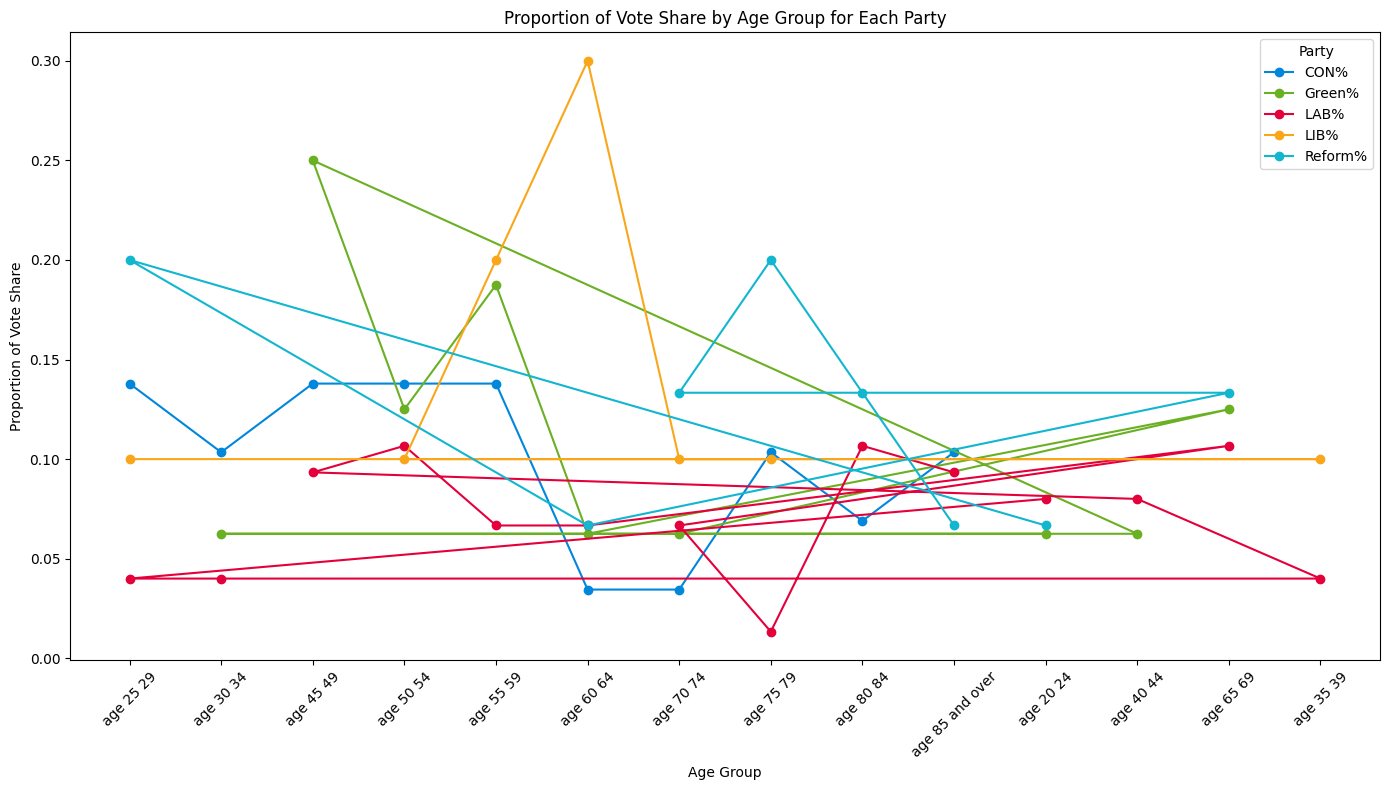

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('fake_polling_data.csv')

# Assuming 'Vote Intention' is 'y' for yes and 'n' for no
# We will create a new column 'Vote Count' where 'y' is 1 and 'n' is 0
df['Vote Count'] = df['Vote Intention'].apply(lambda x: 1 if x == 'y' else 0)

# Filter only rows where vote intention is 'y'
df_yes_votes = df[df['Vote Intention'] == 'y']

# Group by 'Party' and 'Age Group', and count the votes
grouped = df_yes_votes.groupby(['Party', 'Age Group']).size().reset_index(name='Votes')

# Calculate the total votes per party
total_votes_per_party = grouped.groupby('Party')['Votes'].sum().reset_index(name='Total Votes')

# Merge to get total votes per party in the grouped DataFrame
grouped = grouped.merge(total_votes_per_party, on='Party')

# Calculate the proportion of votes from each age group
grouped['Proportion'] = grouped['Votes'] / grouped['Total Votes']

# Define party colors
party_colors = {
    "CON%": "#0087DC",  # Conservative blue
    "LAB%": "#E4003B",       # Labour red
    "LIB%": "#FAA61A",        # Green party green
    "Reform%": "#12B6CF",  
    "Green%": "#6AB023",        
}

# Plotting
plt.figure(figsize=(14, 8))
for party in grouped['Party'].unique():
    party_data = grouped[grouped['Party'] == party]
    plt.plot(party_data['Age Group'], party_data['Proportion'], label=party, marker='o', color=party_colors[party])

plt.title('Proportion of Vote Share by Age Group for Each Party')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Vote Share')
plt.xticks(rotation=45)
plt.legend(title='Party')
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
from datetime import datetime

# Load the CSV file
df = pd.read_csv('poll_results.csv')

# Function to parse dates and extract the first date in the range
def parse_date(date_range):
    start_date = date_range.split('-')[0].strip()
    return datetime.strptime(start_date, '%d %b %Y')

# Apply the date parsing function to the 'Sample dates' column
df['Sample dates'] = df['Sample dates'].apply(parse_date)

# Convert percentage columns to numeric, ensuring non-convertible values are handled
percentage_columns = ['CON%', 'LAB%', 'LIB%', 'Reform%', 'Green%']
for col in percentage_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, setting errors to 'coerce' to handle non-numeric data

# Set the period for resampling
df.set_index('Sample dates', inplace=True)
df.index = pd.to_datetime(df.index)

# Resample the data into 3-month periods and calculate the mean for numeric columns only
resampled_df = df[percentage_columns].resample('3M').mean()

# Reset the index to make 'Sample dates' a column again
resampled_df.reset_index(inplace=True)

# Save the aggregated data to a new CSV file
resampled_df.to_csv('aggregated_polls.csv', index=False)

/var/folders/9d/jc2663851_lgqff4sx4jlfz40000gn/T/ipykernel_92058/4090875296.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_df = df[percentage_columns].resample('3M').mean()


In [80]:
import pandas as pd
import random

# Load the population data from the CSV file
demographics_df = pd.read_csv('demographic_data.csv')

# Load electorate turnout data
turnout_df = pd.read_csv('electorate-turnout.csv')

# Load constituency to geography mapping
constituency_lookup_df = pd.read_csv('lad_constituency_lookup.csv')

# Load aggregated poll results
polls_df = pd.read_csv('aggregated_polls.csv')

# Normalize weights to create a probability distribution for each date
polls_df.set_index('Sample dates', inplace=True)
party_weights_by_date = {}
for date, row in polls_df.iterrows():
    weights = row.to_dict()
    total = sum(weights.values())
    normalized_weights = {party: weight / total for party, weight in weights.items()}
    party_weights_by_date[date] = normalized_weights

# Function to choose a party based on weights
def choose_party(weights):
    parties, probs = zip(*weights.items())
    return random.choices(parties, weights=probs, k=1)[0]

# Function to randomly select an age group based on population distribution
def choose_age_group(row):
    excluded_groups = ['age 0 4', 'age 5 9', 'age 10 14', 'age 15 19']
    age_groups = [col for col in row.index if 'age' in col and col not in excluded_groups and pd.notna(row[col]) and row[col] > 0]
    populations = [row[age] for age in age_groups]
    total_population = sum(populations)
    if total_population == 0:
        return None  # Handle cases where no population data is available
    probabilities = [p / total_population for p in populations]
    return random.choices(age_groups, weights=probabilities, k=1)[0]

# Generate fake polling data with history
data = []
voter_history = {}  # Dictionary to store previous party choice for each voter

for index, row in demographics_df.iterrows():
    geography = row['geography']
    population = int(row['population'])
    num_rows = population // 100  # Generate one row per 100 people

    # Get electorate turnout for the geography's (LAD) constituency by matching LAD22NM in constituency_lookups_df with PCON22NM. 
    constituency_matches = constituency_lookup_df[constituency_lookup_df['LAD22NM'] == geography]
    if not constituency_matches.empty:
        constituency_name = constituency_matches['PCON22NM'].iloc[0]
        electorate_info = turnout_df[turnout_df['Constituency name'] == constituency_name]
        if not electorate_info.empty:
            total_votes = electorate_info['Valid votes'].iloc[0]
            total_electorate = electorate_info['Electorate'].iloc[0]
            overall_turnout = (total_votes / total_electorate) * 100

            # Get possible geographies for the constituency
            geographies = constituency_lookup_df[constituency_lookup_df['PCON22NM'] == constituency_name]['LAD22NM'].tolist()

            for _ in range(num_rows):
                if not geographies:
                    continue  # Skip if no geographies are found for the constituency
                location = random.choice(geographies)  # Randomly select a geography
                age_group = choose_age_group(row)
                if age_group is None:
                    continue  # Skip if no valid age group is found
                
                voter_id = (constituency_name, _)
                previous_party = voter_history.get(voter_id, None)
                voter_data = [constituency_name, location, 'y', age_group]

                for current_date in sorted(party_weights_by_date.keys()):
                    current_weights = party_weights_by_date[current_date]

                    if previous_party and random.random() < 0.8:  # 80% chance to keep the same party
                        party = previous_party
                    else:
                        party = choose_party(current_weights)
                    
                    voter_history[voter_id] = party
                    voter_data.append(party)
                    previous_party = party

                data.append(voter_data)

# Create a DataFrame with dynamic columns for each 3-month period
columns = ['Constituency', 'LTLA', 'Vote Intention', 'Age Group'] + [f'Party_{date}' for date in sorted(party_weights_by_date.keys())]
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv('fake_polling_data_with_history.csv', index=False)
               

In [98]:
import pandas as pd

# Load the data
df = pd.read_csv('fake_polling_data_with_history.csv')

# Clean column names by stripping any leading/trailing whitespace
df.columns = df.columns.str.strip()

# Display the first few rows of the dataframe
print(df.head())

import statsmodels.api as sm
import patsy

# Define the formula for the model
formula = 'C(Party) ~ C(Age_Group) + C(LTLA)'

# Initialize a dictionary to store results for each period
results = {}

# Loop through each period and fit the model
for period in df.columns[4:]:  # Skip the first four columns which are not periods
    print(f"Processing period: {period}")
    
    # Create a temporary DataFrame for the current period
    temp_df = df[['Age_Group', 'LTLA', period]].dropna()
    temp_df = temp_df.rename(columns={period: 'Party'})
    
    # Ensure the Party column is treated as a categorical variable
    temp_df['Party'] = temp_df['Party'].astype('category')
    
    # Create the design matrices
    y, X = patsy.dmatrices(formula, data=temp_df, return_type='dataframe')
    
    # Fit the model using a multinomial logistic regression
    try:
        model = sm.MNLogit(y, X)
        result = model.fit()
        
        # Store the result
        results[period] = result

        # Print the summary of the model
        print(result.summary())
    except Exception as e:
        print(f"Error processing period {period}: {e}")

# Example population distribution dataframe
population_data = {
    'Age_Group': ['age 20 24', 'age 25 29', 'age 30 34', 'age 35 39', 'age 40 44'],
    'LTLA': ['Location1', 'Location2', 'Location3', 'Location4', 'Location5'],
    'Population': [1000, 1500, 2000, 2500, 3000]
}
population_df = pd.DataFrame(population_data)

# Initialize a DataFrame to store the weighted average probabilities
weighted_avg_probabilities = pd.DataFrame(columns=['Period', 'Weighted_Avg_Probability'])

# Loop through each period and calculate the weighted average probability
for period, result in results.items():
    # Predict the probabilities for each combination of age group and geography
    population_df['Party_Probability'] = result.predict(patsy.dmatrix(formula, data=population_df, return_type='dataframe'))
    
    # Calculate the weighted average of the probabilities based on the population distribution
    weighted_avg_probability = (population_df['Party_Probability'] * population_df['Population']).sum() / population_df['Population'].sum()
    
    # Append the result to the DataFrame
    weighted_avg_probabilities = weighted_avg_probabilities.append({'Period': period, 'Weighted_Avg_Probability': weighted_avg_probability}, ignore_index=True)

# Display the results in an easily readable format
print("Weighted Average Probability of Voting for the Party:")
print(weighted_avg_probabilities)

# Save the results to a CSV file
weighted_avg_probabilities.to_csv('weighted_avg_probabilities.csv', index=False)
print("Results saved to 'weighted_avg_probabilities.csv'")

  Constituency        LTLA Vote Intention  Age_Group Party_2019-12-31  \
0   Hartlepool  Hartlepool              y  age 70 74             CON%   
1   Hartlepool  Hartlepool              y  age 70 74           Green%   
2   Hartlepool  Hartlepool              y  age 30 34             LAB%   
3   Hartlepool  Hartlepool              y  age 55 59             LIB%   
4   Hartlepool  Hartlepool              y  age 35 39             LAB%   

  Party_2020-03-31 Party_2020-06-30 Party_2020-09-30 Party_2020-12-31  \
0             CON%             CON%             CON%             CON%   
1           Green%             LIB%             LAB%             LAB%   
2             LAB%             LAB%             LAB%             LAB%   
3             LIB%             LIB%             LIB%             LIB%   
4             CON%             CON%             CON%             CON%   

  Party_2021-03-31  ... Party_2022-03-31 Party_2022-06-30 Party_2022-09-30  \
0             CON%  ...             CON%    

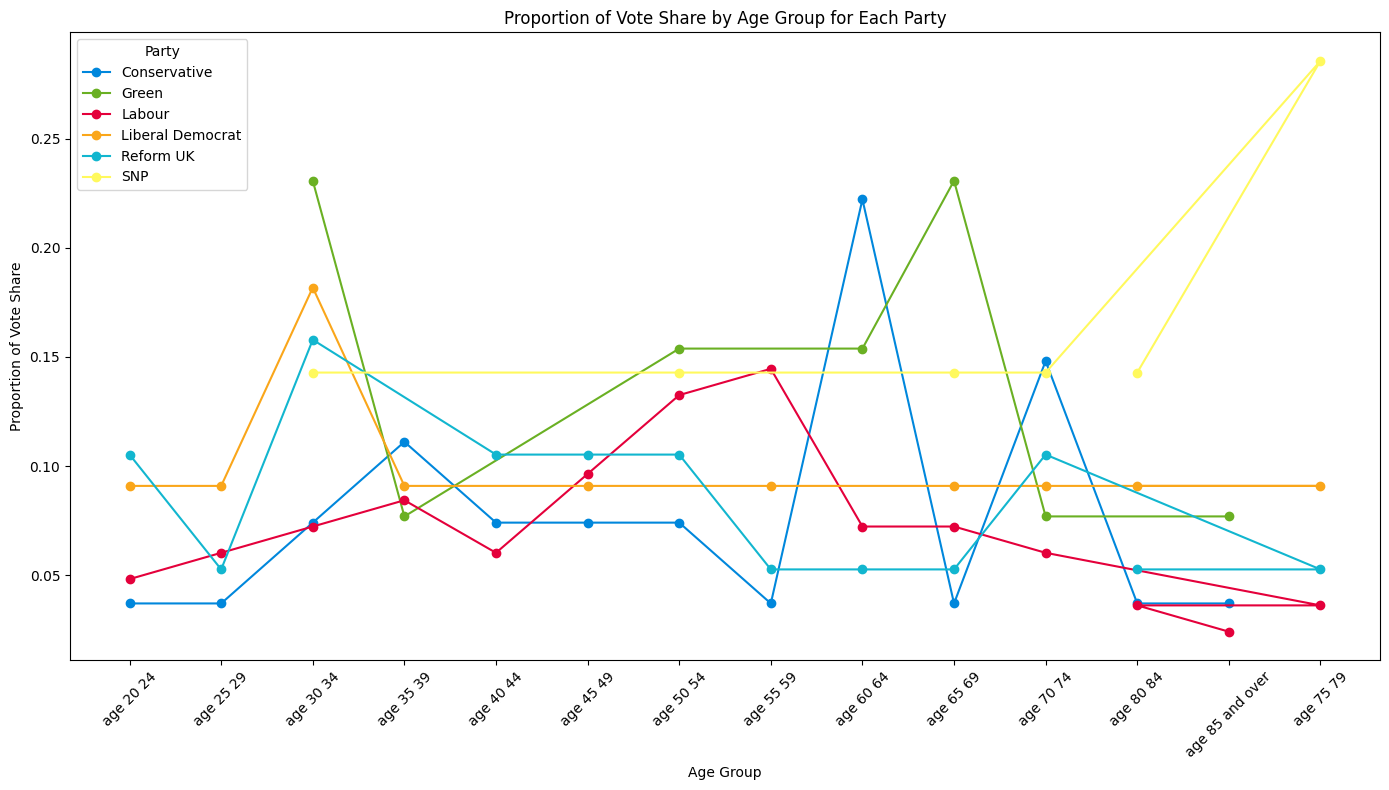

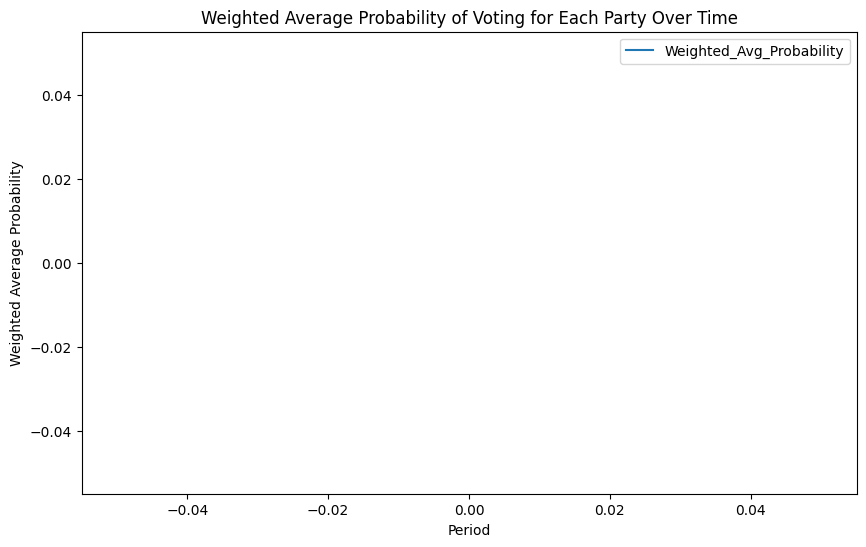

In [99]:
import matplotlib.pyplot as plt

# Plotting the weighted average probabilities over time
plt.figure(figsize=(10, 6))
for party in weighted_avg_probabilities.columns[1:]:
    plt.plot(weighted_avg_probabilities['Period'], weighted_avg_probabilities[party], label=party)

plt.xlabel('Period')
plt.ylabel('Weighted Average Probability')
plt.title('Weighted Average Probability of Voting for Each Party Over Time')
plt.legend()
plt.show()

In [233]:
import pandas as pd

# Load the aggregated polls data
aggregated_polls = pd.read_csv('aggregated_polls.csv')

# Normalize the probabilities for each row
probability_columns = ['CON%', 'LAB%', 'LIB%', 'Reform%', 'Green%']
aggregated_polls[probability_columns] = aggregated_polls[probability_columns].div(aggregated_polls[probability_columns].sum(axis=1), axis=0)

# Save the adjusted data back to the CSV file
aggregated_polls.to_csv('aggregated_polls_normalized.csv', index=False)

print("Aggregated polls have been normalized and saved to 'aggregated_polls_normalized.csv'.")

Aggregated polls have been normalized and saved to 'aggregated_polls_normalized.csv'.


In [297]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(123)

# Load polling data from aggregated_polls.csv
polling_data = pd.read_csv('aggregated_polls_normalized.csv')

# Generate the date range
dates = polling_data['Dates']

# Define the number of individuals
n_individuals = 10000

# Define age categories and their turnout rates
age_group_turnout = {
    'age 20 24': 54.5, 'age 25 29': 54.4, 'age 30 34': 60.9, 'age 35 39': 60.9,
    'age 40 44': 71.0, 'age 45 49': 71.0, 'age 50 54': 72.8, 'age 55 59': 72.8,
    'age 60 64': 78.5, 'age 65 69': 78.5, 'age 70 74': 78.5, 'age 75 79': 78.5,
    'age 80 84': 78.5, 'age 85 and over': 78.5
}

# Normalize age group probabilities based on turnout rates
total_turnout = sum(age_group_turnout.values())
age_probabilities = [turnout / total_turnout for turnout in age_group_turnout.values()]
age_categories = list(age_group_turnout.keys())

# Read the ethnicity data from the CSV file
ethnicity_data = pd.read_csv('ethnicity_census_rgn.csv')

# Calculate the total population for each ethnicity category
ethnicity_totals = ethnicity_data.iloc[:, 4:].sum()

# Calculate the probabilities for each ethnicity category
ethnicity_probabilities = ethnicity_totals / ethnicity_totals.sum()
ethnicity_categories = ethnicity_totals.index.tolist()

# Define geography categories (UK regions) and their probabilities
geography_categories = ['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'East', 'London', 'South East', 'South West', 'Wales']
geography_probabilities = [0.08, 0.11, 0.08, 0.09, 0.09, 0.09, 0.19, 0.14, 0.1, 0.03]


# Define parties and their probabilities
parties = ['Conservative', 'Labour', 'Liberal Democrat', 'Reform UK', 'Green']
party_probabilities = [0.2453, 0.4399, 0.0979, 0.1579, 0.059]


# Create an empty DataFrame to store the data
data = pd.DataFrame(columns=['Date', 'Age', 'Ethnicity', 'Geography', 'Voting Intention'])

def get_voting_probabilities(age, ethnicity, geography, probabilities):
    
    # Initialize biases for each category
    age_biases = [1, 1, 1, 1, 1]
    geography_biases = [1, 1, 1, 1, 1]
    ethnicity_biases = [1, 1, 1, 1, 1]
    
    # Apply age biases
    if 'age 50' in age or 'age 55' in age or 'age 60' in age or 'age 65' in age or 'age 70' in age or 'age 75' in age or 'age 80' in age or 'age 85' in age:
        age_biases = [1.5, 0.5, 0.5, 1.4, 0.5]
    elif 'age 20' in age or 'age 25' in age or 'age 30' in age:
        age_biases = [0.5, 1.5, 1.5, 0.5, 1.5]
    
    # Apply geography biases
    if geography in ['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'London']:
        geography_biases = [0.5, 1.65, 0.5, 1.25, 0.5]
    elif geography in ['South East', 'South West', 'Wales', 'West Midlands']:
        geography_biases = [1.65, 0.3, 1.1, 1.15, 1.1]
    
    # Apply ethnicity biases
    if ethnicity not in ['White']:
        ethnicity_biases = [0.7, 1.5, 1.5, 0.5, 1.5]
    
    # Combine biases
    combined_biases = [a * g * e for a, g, e in zip(age_biases, geography_biases, ethnicity_biases)]
    
    # Apply combined biases to default probabilities
    adjusted_probabilities = [p * b for p, b in zip(probabilities, combined_biases)]
    
    # Normalize to ensure they sum to 1
    total = sum(adjusted_probabilities)
    normalized_probabilities = [p / total for p in adjusted_probabilities]
    
    return normalized_probabilities
    
# Generate fake data for each date
data_list = []
for date in dates:
    # Generate age categories
    probabilities = polling_data[polling_data['Dates'] == date].iloc[0, 1:].tolist()

    ages = np.random.choice(age_categories, size=n_individuals, p=age_probabilities)
    
    # Generate ethnicity categories
    ethnicities = np.random.choice(ethnicity_categories, size=n_individuals, p=ethnicity_probabilities)
    
    # Generate geography categories
    geographies = np.random.choice(geography_categories, size=n_individuals, p=geography_probabilities)
    
    # Generate voting intentions
    voting_intentions = [
        np.random.choice(parties, p=get_voting_probabilities(age, ethnicity, geography, probabilities))
        for age, ethnicity, geography in zip(ages, ethnicities, geographies)
    ]
    
    # Create a temporary DataFrame for the current date
    temp_df = pd.DataFrame({'Date': date, 'Age': ages, 'Ethnicity': ethnicities, 'Geography': geographies, 'Voting Intention': voting_intentions})
    
    # Append the temporary DataFrame to the list
    data_list.append(temp_df)

# Concatenate all DataFrames in the list
data = pd.concat(data_list, ignore_index=True)

# Save the generated data to a CSV file
data.to_csv('fake_polling_data.csv', index=False)

print("Fake polling data has been saved to 'fake_polling_data.csv'.")

Fake polling data has been saved to 'fake_polling_data.csv'.


In [335]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Load data
data = pd.read_csv('fake_polling_data.csv', parse_dates=['Date'])
age_census = pd.read_csv('age_census_rgn.csv')
ethnicity_census = pd.read_csv('ethnicity_census_rgn.csv')

# Filter out age groups below 20
age_columns = [col for col in age_census.columns if 'Age: Aged' in col and 'years and under' not in col and '5 to 9' not in col and '10 to 14' not in col and '15 to 19' not in col]
age_totals = age_census[age_columns].sum()
age_actual_distribution = (age_totals / age_totals.sum()).to_dict()

# Calculate the actual distribution of ethnicities in the population
ethnicity_columns = [col for col in ethnicity_census.columns if 'Ethnic group:' in col and 'Total' not in col]
ethnicity_totals = ethnicity_census[ethnicity_columns].sum()
ethnicity_actual_distribution = (ethnicity_totals / ethnicity_totals.sum()).to_dict()

# Combine all possible labels from both data and actual distribution
all_age_labels = set(data['Age'].unique()).union(set(age_actual_distribution.keys()))
all_ethnicity_labels = set(data['Ethnicity'].unique()).union(set(ethnicity_actual_distribution.keys()))
all_geography_labels = set(data['Geography'].unique()).union(set(data['Geography'].unique()))

# Sort the geography labels to ensure consistent ordering
sorted_geography_labels = sorted(all_geography_labels)

# Encode the categorical variables using LabelEncoder
label_encoder_age = LabelEncoder().fit(list(all_age_labels))
label_encoder_ethnicity = LabelEncoder().fit(list(all_ethnicity_labels))
label_encoder_geography = LabelEncoder().fit(sorted_geography_labels)

data['Age'] = label_encoder_age.transform(data['Age'])
data['Ethnicity'] = label_encoder_ethnicity.transform(data['Ethnicity'])
data['Geography'] = label_encoder_geography.transform(data['Geography'])

# Encode the dependent variable (voting intention) using LabelEncoder
label_encoder_voting = LabelEncoder()
data['Voting Intention'] = label_encoder_voting.fit_transform(data['Voting Intention'])

# Perform multilevel logistic regression
model = sm.MNLogit(data['Voting Intention'], sm.add_constant(data[['Age', 'Ethnicity', 'Geography']]))
result = model.fit()

print(result.summary())

print("\nResult object structure:")
print(dir(result))

# Print the structure of key attributes
print("\nParams structure:")
print(result.params)

print("\nP-values structure:")
print(result.pvalues)

print("\nConfidence Intervals structure:")
print(result.conf_int())

print("\nT-values structure:")
print(result.tvalues)

# Save the model and result to a file
with open('mnlogit_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('mnlogit_result.pkl', 'wb') as f:
    pickle.dump(result, f)

# Create a DataFrame with all possible combinations of age, ethnicity, and geography
age_labels = list(age_actual_distribution.keys())
ethnicity_labels = list(ethnicity_actual_distribution.keys())
geography_labels = sorted_geography_labels

age_encoded = label_encoder_age.transform(age_labels)
ethnicity_encoded = label_encoder_ethnicity.transform(ethnicity_labels)
geography_encoded = label_encoder_geography.transform(geography_labels)

combinations = pd.DataFrame(
    np.array(np.meshgrid(age_encoded, ethnicity_encoded, geography_encoded)).T.reshape(-1, 3),
    columns=['Age', 'Ethnicity', 'Geography']
)

# Predict probabilities for each combination
predicted_probs = result.predict(sm.add_constant(combinations))

# Calculate the weighted average of predicted probabilities using actual distributions
age_weights = np.array([age_actual_distribution[label] for label in age_labels])
ethnicity_weights = np.array([ethnicity_actual_distribution[label] for label in ethnicity_labels])
geography_weights = np.ones(len(geography_labels)) / len(geography_labels)  # Assuming equal distribution for simplicity

weights = np.outer(np.outer(age_weights, ethnicity_weights), geography_weights).reshape(-1)

weighted_probs = predicted_probs * weights[:, np.newaxis]

# Calculate vote share for each region
region_vote_shares = {}
for i, geography in enumerate(geography_labels):
    region_weights = weights.reshape(len(age_labels), len(ethnicity_labels), len(geography_labels))[:, :, i].flatten()
    region_probs = predicted_probs[i::len(geography_labels)]
    region_weighted_probs = region_probs * region_weights[:, np.newaxis]
    region_vote_shares[geography] = region_weighted_probs.sum(axis=0)

# Prepare data for DataFrame
data = []
for region, vote_share in region_vote_shares.items():
    row = [region] + vote_share.tolist()
    data.append(row)

# Define columns
columns = ['Region'] + label_encoder_voting.classes_.tolist()

# Create DataFrame
vote_share_df = pd.DataFrame(data, columns=columns)

# Save the vote share data to a CSV file
vote_share_df.to_csv('region_vote_shares.csv', index=False)

print(vote_share_df)

# Save the label encoders for later use
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump({
        'age': label_encoder_age,
        'ethnicity': label_encoder_ethnicity,
        'geography': label_encoder_geography,
        'voting': label_encoder_voting
    }, f)

Optimization terminated successfully.
         Current function value: 1.137207
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:       Voting Intention   No. Observations:               190000
Model:                        MNLogit   Df Residuals:                   189984
Method:                           MLE   Df Model:                           12
Date:                Fri, 24 May 2024   Pseudo R-squ.:                 0.05307
Time:                        20:23:37   Log-Likelihood:            -2.1607e+05
converged:                       True   LL-Null:                   -2.2818e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
Voting Intention=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8208      0.072     25.285      0.000       1.680       1.962
Age  

In [310]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import LabelEncoder
import pickle

# Load MRP results
with open('mnlogit_result.pkl', 'rb') as f:
    result = pickle.load(f)
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

# Load region vote shares
vote_share_df = pd.read_csv('region_vote_shares.csv', index_col=0)

# Load monthly polling data
polling_data = pd.read_csv('fake_polling_data.csv', parse_dates=['Date'])

# Encode categorical variables using the saved label encoders
polling_data['Age'] = label_encoders['age'].transform(polling_data['Age'])
polling_data['Ethnicity'] = label_encoders['ethnicity'].transform(polling_data['Ethnicity'])
polling_data['Geography'] = label_encoders['geography'].transform(polling_data['Geography'])
polling_data['Voting Intention'] = label_encoders['voting'].transform(polling_data['Voting Intention'])

# Decode the geography and voting intention columns to match the region names in vote_share_df
polling_data['Geography'] = label_encoders['geography'].inverse_transform(polling_data['Geography'])
polling_data['Voting Intention'] = label_encoders['voting'].inverse_transform(polling_data['Voting Intention'])

# Extract unique regions from polling data
unique_regions = polling_data['Geography'].unique()

# Initialize a DataFrame to hold merged data
merged_data = pd.DataFrame()

# Iterate through each region to merge data
for region in unique_regions:
    # Extract vote share data for the region
    region_vote_shares = vote_share_df.loc[region].reset_index()
    region_vote_shares.columns = ['Voting Intention', 'Vote_Share_MRP']
    region_vote_shares['Geography'] = region
    
    # Merge the region-specific vote share data with polling data
    region_polling_data = polling_data[polling_data['Geography'] == region]
    region_merged_data = pd.merge(region_polling_data, region_vote_shares, on=['Geography', 'Voting Intention'])
    
    # Append to the main merged_data DataFrame
    merged_data = pd.concat([merged_data, region_merged_data])

# Pivot the data to have a multi-index time series
pivoted_data = merged_data.pivot_table(index='Date', columns=['Geography', 'Voting Intention'], values='Vote_Share_MRP')

# Check for stationarity and difference if needed
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    if series.nunique() == 1:
        return True
    result = adfuller(series.dropna())
    return result[1] < 0.05  # p-value < 0.05

for column in pivoted_data.columns:
    if not check_stationarity(pivoted_data[column]):
        pivoted_data[column] = pivoted_data[column].diff().dropna()

# Split into training and testing sets
train = pivoted_data[:int(0.8*len(pivoted_data))]
test = pivoted_data[int(0.8*len(pivoted_data)):]

# Determine optimal lag length
model = VAR(train)
lag_order = model.select_order()
lags = lag_order.aic  # or use bic, hqic

# Fit the VAR model
var_model = model.fit(lags)

# Forecasting
forecast = var_model.forecast(train.values[-lags:], steps=len(test))

# Convert forecast to dataframe
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Evaluate the forecast
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test.values, forecast)
print(f'Mean Squared Error: {mse}')

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for region in test.columns.levels[0]:
    for party in test.columns.levels[1]:
        plt.plot(test.index, test[(region, party)], label=f'True {region} - {party}')
        plt.plot(forecast_df.index, forecast_df[(region, party)], label=f'Forecast {region} - {party}', linestyle='--')
plt.legend()
plt.show()


/Users/cardigan/llm-datawarehouse/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/cardigan/llm-datawarehouse/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/cardigan/llm-datawarehouse/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/cardigan/llm-datawarehouse/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/cardigan/llm-datawarehouse/venv/lib/python3.12/site-packages/statsmodels/regressi

KeyError: 'aic'

Mean Squared Error: 14.280992923711144


/var/folders/9d/jc2663851_lgqff4sx4jlfz40000gn/T/ipykernel_92058/2867659910.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=120, freq='M')


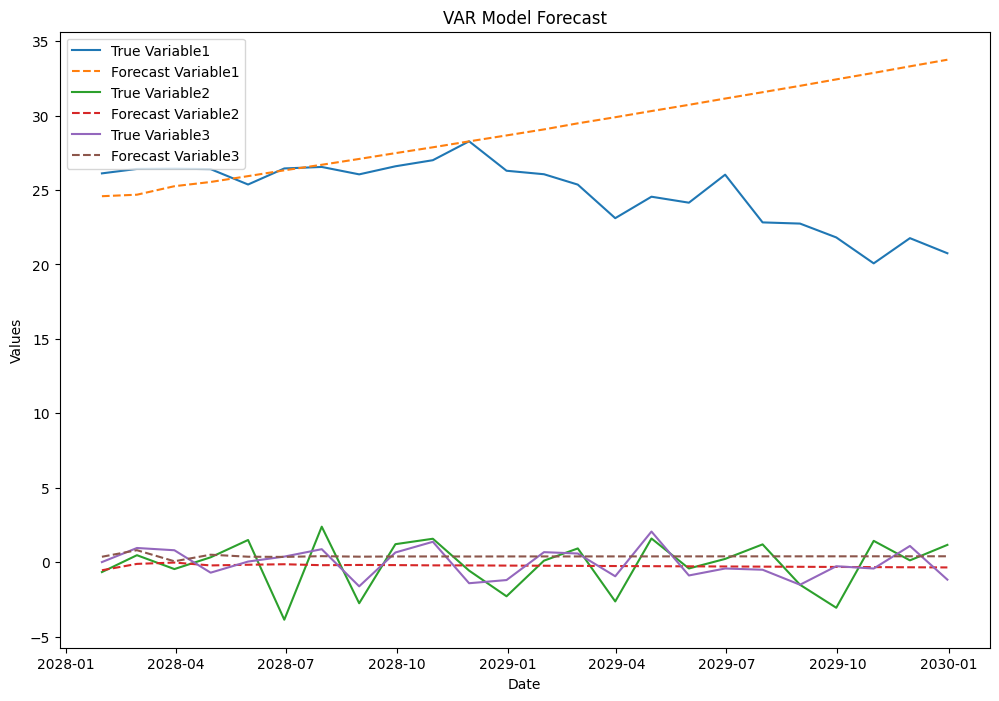

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Step 1: Create Sophisticated Sample Data
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=120, freq='M')

# Create underlying trends
trend1 = np.linspace(0, 20, 120)
trend2 = np.linspace(5, 25, 120)
trend3 = np.linspace(10, 30, 120)

# Create seasonality
seasonality1 = 10 * np.sin(np.linspace(0, 3 * np.pi, 120))
seasonality2 = 5 * np.cos(np.linspace(0, 3 * np.pi, 120))
seasonality3 = 3 * np.sin(np.linspace(0, 3 * np.pi, 120))

# Create noise
noise1 = np.random.normal(0, 1, 120)
noise2 = np.random.normal(0, 1, 120)
noise3 = np.random.normal(0, 1, 120)

# Combine them to create the variables
data1 = trend1 + seasonality1 + noise1
data2 = trend2 + seasonality2 + noise2
data3 = trend3 + seasonality3 + noise3

# Create correlation between variables
data2 = data2 + 0.5 * data1
data3 = data3 + 0.3 * data1 + 0.3 * data2

df = pd.DataFrame({'Variable1': data1, 'Variable2': data2, 'Variable3': data3}, index=dates)

# Step 2: Preprocess Data (Check for stationarity and difference if needed)
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    return result[1] < 0.05  # p-value < 0.05

# Differencing if necessary
for column in df.columns:
    if not check_stationarity(df[column]):
        df[column] = df[column].diff().dropna()

# Drop initial rows with NaN values after differencing
df = df.dropna()

# Step 3: Fit VAR Model
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Fit the model
model = VAR(train)
lag_order = model.select_order(maxlags=15)
lags = lag_order.selected_orders.get('bic', 1)  # Use BIC or default to 1

# Ensure lags is not zero
if lags == 0:
    lags = 1

var_model = model.fit(lags)

# Step 4: Make Forecasts
forecast = var_model.forecast(train.values[-lags:], steps=len(test))

# Convert forecast to dataframe
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Step 5: Evaluate and Plot Forecasts
mse = mean_squared_error(test.values, forecast)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(12, 8))
for col in test.columns:
    plt.plot(test.index, test[col], label=f'True {col}')
    plt.plot(forecast_df.index, forecast_df[col], label=f'Forecast {col}', linestyle='--')
plt.legend()
plt.title('VAR Model Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()
